In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 10 2024

@author: Yaning
Suggested by Sascha
"""

import torch
import pyro
import math
import pandas as pd
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Gamma
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning
from pyro import poutine
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
class Agent:
    def __init__(self, ds_rate, dev_rate):
        # free parameters (the mean and variant of the estimate value)
        self.ds_rate = ds_rate
        self.dev_rate = dev_rate


    def estimation(self, curr_LL, curr_delay, curr_SS):
        # the estimate value is assumed to be a normal distribution
        # the estimate value mean is assumed to LL/1+kt
        # the initial estimation variance is 2 and increase rate is 0.05
        self.LL_es_mu = curr_LL/(1+self.ds_rate*curr_delay)
        self.LL_es_sigma = torch.exp(torch.tensor(self.dev_rate*curr_delay))*3
        # the fixed early and small value
        self.curr_SS = curr_SS


    def generate_action(self):
        # 1 means choosing large later
        # pyro distribution is used (i guess it is the same as torch's distribution)
        # somehow using binomial or bernoulli is a bit slower to generate the data
        # maybe because there are two distributions? 
        LL_distri = Normal(loc = torch.tensor(self.LL_es_mu), scale =self.LL_es_sigma)
        chose_LL_pobs = 1 - LL_distri.cdf(torch.tensor(self.curr_SS))
        LL_bino = Binomial(probs = chose_LL_pobs)
        return LL_bino.sample().item()

In [10]:
# discounting rate is 1/16, the uncertainty which is the initial variance is 2
# the increase rate is 0.05
agent = Agent(1/16, 0.001)

LL_values = []
combinations = []
# future tensor for inference specifically
inference_actions = []
inference_ss_values = []
inference_ll_values = []
inference_delays = []

actions = []
choose_percentage = []

# initialise trial combinations
repetition = 10
delays = [1, 3, 7, 13, 24, 32, 45, 58, 75, 122]
SS_values = [5]
# values by percentage
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]


# get the LL_values
for S in SS_values:
    for L in LL_values_p:
        LL_values.append(S*L)

# combinations has three parameters: SS_value, LL_value, delay
for S in SS_values:
    for delay in delays:
        for L in LL_values:
            combinations.append([L, delay, S])

for trial in combinations:
    one_combination_action = []
    for repeat in range(repetition):
        # parameters estimation needs: curr_LL, curr_delay, curr_SS
        agent.estimation(trial[0], trial[1], trial[2])
        generated_action = agent.generate_action()

        # arrays that are used for inference
        inference_ll_values.append(trial[0])
        inference_delays.append(trial[1])
        inference_ss_values.append(trial[2])
        inference_actions.append(generated_action)

        one_combination_action.append(generated_action)

    # 1 means choose large later
    choose_percentage.append((len(list(filter(lambda x: (x == 1), one_combination_action))) / len(one_combination_action)) * 100)
    actions.append(one_combination_action)


 
d = {'combinations':combinations, 'actions': actions, 'choose_percentage': choose_percentage}
df = pd.DataFrame(data=d)
print(df)
print(inference_actions)

                   combinations  \
0                  [5.25, 1, 5]   
1    [5.2749999999999995, 1, 5]   
2                  [5.75, 1, 5]   
3                  [6.25, 1, 5]   
4                  [6.75, 1, 5]   
..                          ...   
165             [12.75, 122, 5]   
166             [14.25, 122, 5]   
167             [15.25, 122, 5]   
168             [17.25, 122, 5]   
169             [19.25, 122, 5]   

                                               actions  choose_percentage  
0    [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...               50.0  
1    [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...               40.0  
2    [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...               50.0  
3    [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...               60.0  
4    [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...               70.0  
..                                                 ...                ...  
165  [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0

In [12]:

actions = torch.tensor(inference_actions)
delays = torch.tensor(inference_delays)
ss_values = torch.tensor(inference_ss_values)
ll_values = torch.tensor(inference_ll_values)
# print(actions)
# print(delays)
# print(ss_values)
# print(ll_values)

def model(actions, delays, ss_values, ll_values):
    dev_rate = pyro.sample("dev_rate", Gamma(torch.tensor([1.2]), torch.tensor([1.])))
    # dev_rate = pyro.sample("dev_rate", Beta(torch.tensor([10.]), torch.tensor([10.])))
    rate = pyro.sample("rate", HalfCauchy(scale= torch.tensor([1.])))
    num = actions.shape[0]
    with pyro.plate("num", num):
        mean = ll_values/(1+rate*delays)
        dev = torch.exp(dev_rate*delay)*2
        distri = Normal(loc = mean, scale = dev)
        pos = 1 - distri.cdf(ss_values)
        return pyro.sample("obs", Binomial(probs = pos), obs=actions)

# pyro.render_model(model, model_args=(actions, delays, ss_values, ll_values), render_params=True, render_distributions=True)



mcmc_kernel = NUTS(model)                                               # initialize proposal distribution kernel
mcmc = MCMC(mcmc_kernel, num_samples=500, num_chains = 3, warmup_steps=80)  # initialize MCMC class
mcmc.run(actions, delays, ss_values, ll_values)

Warmup [1]:   0%|          | 0/580 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/580 [00:00, ?it/s]

/home/parzi3mis/documents/pyro_models/pyro/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Warmup [3]:   0%|          | 0/580 [00:00, ?it/s]

/home/parzi3mis/documents/pyro_models/pyro/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/parzi3mis/documents/pyro_models/pyro/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


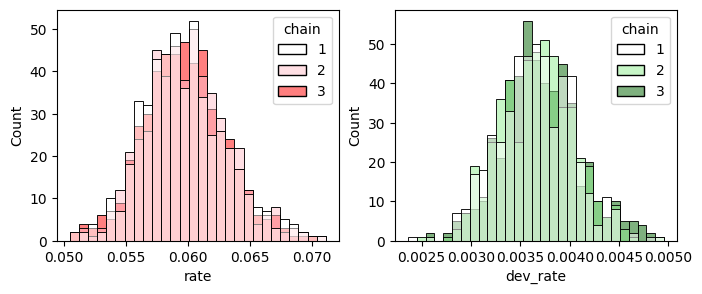

In [13]:
# mcmc.summary()
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

rate = pd.DataFrame(mcmc.get_samples()['rate'],columns=['rate'])
rate['chain'] = torch.tensor([1,2,3]).repeat(500)
sns.histplot(data=rate, x='rate',hue='chain', palette=['white', 'pink', 'red'], ax=axs[0])

dev_rate = pd.DataFrame(mcmc.get_samples()['dev_rate'],columns=['dev_rate'])
dev_rate['chain'] = torch.tensor([1,2,3]).repeat(500)
sns.histplot(data=dev_rate, x='dev_rate',hue='chain', palette=['white', 'lightgreen', 'darkgreen'], ax=axs[1])

plt.show()